![header](../06-img/header-02-05-logreg.jpg)

## General Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, precision_score, recall_score, roc_auc_score

In [2]:
data_full = pd.read_csv( '../01-data/data_merged_20220910_norm.csv')
data_full = data_full.query('H_Age<100&Draw>0').reset_index( drop = True)
y = data_full[ 'Winner']

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2406342619.py:1: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  data_full = pd.read_csv( '../01-data/data_merged_20220910_norm.csv')


In [3]:
X = data_full.loc[ :, data_full.columns.str.startswith( 'ActualWeight') | data_full.columns.str.startswith( 'DeclaredHorseWeight') | \
    data_full.columns.str.startswith( 'WinOdds') | data_full.columns.str.startswith( 'Draw') | \
    data_full.columns.str.startswith( 'J_Total_') | data_full.columns.str.startswith( 'J_TotalStakes_') | \
    data_full.columns.str.startswith( 'J_Rate_') | \
    data_full.columns.str.startswith( 'T_Total_') | data_full.columns.str.startswith( 'T_TotalStakes_') | \
    data_full.columns.str.startswith( 'T_Rate') | \
    data_full.columns.str.startswith( 'H_Rate_') | data_full.columns.str.startswith( 'H_Total') | \
    data_full.columns.str.startswith( 'H_TotalStake') | data_full.columns.str.startswith( 'CombinedRating') | \
    data_full.columns.str.startswith( 'H_Age') | data_full.columns.str.startswith( 'WeightDiff') | \
    data_full.columns.str.startswith( 'LastRace_nDays') | data_full.columns.str.startswith( 'PreviousPlace') | \
    data_full.columns.str.startswith( 'AvgPlace3') | data_full.columns.str.startswith( 'AvgPlace5') | \
    data_full.columns.str.startswith( 'Place')] # Place is added for downsampling

print( X.columns)

Index(['Place', 'ActualWeight', 'DeclaredHorseWeight', 'Draw', 'WinOdds',
       'J_Rate_win', 'J_Rate_place', 'J_Rate_show', 'T_Rate_win',
       'T_Rate_place', 'T_Rate_show', 'H_TotalStake', 'H_Total', 'H_Rate_win',
       'H_Rate_place', 'H_Rate_show', 'H_Age', 'LastRace_nDays',
       'PreviousPlace', 'AvgPlace3', 'AvgPlace5', 'WeightDiff',
       'CombinedRating', 'Place_norm', 'ActualWeight_norm',
       'DeclaredHorseWeight_norm', 'Draw_norm', 'WinOdds_norm',
       'J_Rate_win_norm', 'J_Rate_place_norm', 'J_Rate_show_norm',
       'T_Rate_win_norm', 'T_Rate_place_norm', 'T_Rate_show_norm',
       'H_TotalStake_norm', 'H_Total_norm', 'H_Rate_win_norm',
       'H_Rate_place_norm', 'H_Rate_show_norm', 'H_Age_norm',
       'LastRace_nDays_norm', 'PreviousPlace_norm', 'AvgPlace3_norm',
       'AvgPlace5_norm', 'WeightDiff_norm', 'CombinedRating_norm'],
      dtype='object')


In [4]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.8, random_state = 918)

Variables and corresponding transformations. (All relative indexes will not be transformed as they are theoretically normal)


| Variable | Log? | Scaling |
|----------|------|---------|
| ActualWeight | No | Standard |
| DeclaredHorseWeight | No | Standard |
| Draw | No | Standard (_Ordinal_+Scaling) |
| WinOdds | Yes  |Standard |
| J_Rate_* | No | None |
| T_Rate_* | No | None |
| H_TotalStake | Yes | Standard |
| H_Total | Yes | Standard |
| H_Rate_* | No | None |
| H_Age | No | Standard |
| LastRace_nDays | Yes | Standard |
| PreviousPlace | No | Standard |
| AvgPlace* | No | Standard |
| WeightDiff | No | Standard |
| Rating | No | Standard |


In [5]:
cols_std = [
    'ActualWeight', 'DeclaredHorseWeight', 'Draw', 'H_Age', 'PreviousPlace', 'AvgPlace3', 'AvgPlace5', 'WeightDiff', 'CombinedRating']

cols_log_std = [
    'WinOdds', 'H_TotalStake', 'H_Total', 'LastRace_nDays']

cols_passthrough = [
    'J_Rate_win', 'J_Rate_place', 'J_Rate_show', 'T_Rate_win', 'T_Rate_place', 'T_Rate_show',
    'H_Rate_win', 'H_Rate_place', 'H_Rate_show',
    'ActualWeight_norm', 'DeclaredHorseWeight_norm', 'WinOdds_norm',
    'J_Rate_win_norm', 'J_Rate_place_norm', 'J_Rate_show_norm', 'T_Rate_win_norm', 'T_Rate_place_norm', 'T_Rate_show_norm',
    'H_TotalStake_norm', 'H_Total_norm', 'H_Rate_win_norm', 'H_Rate_place_norm', 'H_Rate_show_norm', 'H_Age_norm',
    'LastRace_nDays_norm', 'PreviousPlace_norm', 'AvgPlace3_norm', 'AvgPlace5_norm', 'WeightDiff_norm', 'CombinedRating_norm']

cols_drop = [
    'Place', 'Place_norm', 'Draw_norm']

In [6]:
def log_func(x):
    return np.log(x+1)

In [7]:
log_transformer = FunctionTransformer( log_func)

In [8]:
pipe_log_std = make_pipeline(
    log_transformer, StandardScaler()
)

In [9]:
column_transformer = make_column_transformer(
    ( StandardScaler(), cols_std),
    ( pipe_log_std, cols_log_std),
    ( 'passthrough', cols_passthrough),
    ( 'drop', cols_drop)
)

## Logistic Regression

In [10]:
pipe_logreg = make_pipeline( column_transformer, LogisticRegression( max_iter = 500, solver = 'saga'))

In [11]:
cv_result = cross_validate( pipe_logreg, X_train, y_train, cv = 5, return_train_score = True, scoring = 'precision')

In [12]:
pd.DataFrame( cv_result)

,fit_time,score_time,test_score,train_score
0,0.491554,0.082863,0.666667,0.567568
1,0.458057,0.005179,0.421053,0.616438
2,0.521849,0.004970,0.541667,0.578125
3,0.435042,0.007957,0.538462,0.579710
4,0.488002,0.007000,0.692308,0.582090


In [13]:
pd.DataFrame( cv_result).mean()

fit_time       0.478901
score_time     0.021594
test_score     0.572031
train_score    0.584786
dtype: float64

## Hyperparameter optimization

In [14]:
param_dist = {
    'logisticregression__C': [ 10**x for x in range( -2, 5)],
    'logisticregression__penalty': [ 'none', 'l2', 'l1', 'elasticnet'],
    'logisticregression__l1_ratio': [ 0, 0.5, 1]
}

grid_search = GridSearchCV(
    pipe_logreg, param_dist, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True
)

In [15]:
grid_search.fit( X_train, y_train)

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['ActualWeight',
                                                                          'DeclaredHorseWeight',
                                                                          'Draw',
                                                                          'H_Age',
                                                                          'PreviousPlace',
                                                                          'AvgPlace3',
                                                                          'AvgPlace5',
                                                                          'WeightDiff',
                                                                          'CombinedRating']),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(func=<function log_func...
                                                                        ('drop',
                                                                         'drop',
                                                                         ['Place',
                                                                          'Place_norm',
                                                                          'Draw_norm'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=500,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000,
                                                   10000],
                         'logisticregression__l1_ratio': [0, 0.5, 1],
                         'logisticregression__penalty': ['none', 'l2', 'l1',
                                                         'elasticnet']},
             return_train_score=True, scoring='precision')

In [16]:
results = pd.DataFrame( grid_search.cv_results_)
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score
3,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
5,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
1,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
9,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
23,"{'logisticregression__C': 0.1, 'logisticregres...",0.604664


In [17]:
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).iloc[ 0, 0]

{'logisticregression__C': 0.01,
 'logisticregression__l1_ratio': 0,
 'logisticregression__penalty': 'elasticnet'}

## Final model evaluation

In [18]:
pipe_logreg_opt = make_pipeline( column_transformer, LogisticRegression( max_iter = 500, solver = 'saga', C = 0.01, penalty = 'l2'))

In [19]:
pipe_logreg_opt.fit( X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ActualWeight',
                                                   'DeclaredHorseWeight',
                                                   'Draw', 'H_Age',
                                                   'PreviousPlace', 'AvgPlace3',
                                                   'AvgPlace5', 'WeightDiff',
                                                   'CombinedRating']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function log_func at 0x00000168DED63820>)),
                                                                  ('st...
                                                   'H_TotalStake_norm',
                                                   'H_Total_norm',
                                                   'H_Rate_win_norm',
                                                   'H_Rate_place_norm',
                                                   'H_Rate_show_norm',
                                                   'H_Age_norm',
                                                   'LastRace_nDays_norm',
                                                   'PreviousPlace_norm',
                                                   'AvgPlace3_norm',
                                                   'AvgPlace5_norm',
                                                   'WeightDiff_norm',
                                                   'CombinedRating_norm']),
                                                 ('drop', 'drop',
                                                  ['Place', 'Place_norm',
                                                   'Draw_norm'])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=500, solver='saga'))])

In [20]:
y_hat = pipe_logreg_opt.predict( X_test)

In [21]:
print( confusion_matrix( y_test, y_hat, labels = [ True, False]))
print( classification_report( y_test, y_hat))

[[  108   976]
 [   43 11988]]
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     12031
        True       0.72      0.10      0.17      1084

    accuracy                           0.92     13115
   macro avg       0.82      0.55      0.57     13115
weighted avg       0.91      0.92      0.89     13115



In [38]:
def pr_curve( precision, recall, threshold):
    plot_df = pd.DataFrame( {
        'precision': precision,
        'recall': recall,
        'threshold': threshold
    })

    chart = alt.Chart( plot_df).mark_point().encode(
        x = 'precision',
        y = 'recall',
        tooltip = 'threshold'
    ).properties( height = 300, width = 300)
    return chart


In [39]:
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve( y_test, pipe_logreg_opt.predict_proba( X_test)[ :, 1])
thresholds_logreg = np.append( thresholds_logreg, 1)
pr_curve_logreg = pr_curve( precision_logreg, recall_logreg, thresholds_logreg)

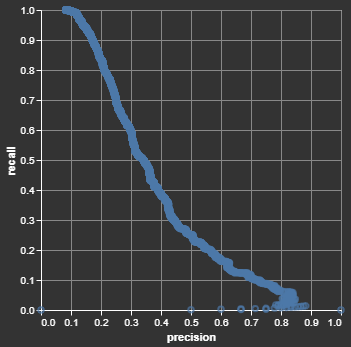

In [40]:
pr_curve_logreg